# ideas

feature engineering
* sequence len
* n-gram frequency, amount of overlap
* sequencing (recurrent)
* group similar labels together
* “ATGC” becomes [0.25, 0.5, 0.75, 1.0] (https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml)
* “ATGC” would become [0,0,0,1], [0,0,1,0], [0,1,0,0], [1,0,0,0] (widely used in dep learning methods and lends itself well to algorithms like convolutional neural networks)
* above methods need truncation or padding to ensure equal length

feature selection
* chi sq test, but need less labels
* get rid of correlated features
* group together similar labels
* pca

machine learning
* multiple models, condition prob b/c imbalanced classes
* models to identify most common classes
* over and under sampling
* how to validation: val set, k fold
* ensure not overfitting
* learning curves

# setup

## libraries

In [9]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load
import os

%matplotlib inline
sns.set()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
os.chdir('/content/drive/My Drive/Colab Notebooks/genetic-engineering-attribution-challenge/code/')

In [12]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None
DATA_DIR = Path.cwd().parent / 'data' 
train = False

## read in data

In [13]:
train_values = pd.read_csv(DATA_DIR / 'train_values.csv', index_col='sequence_id')
train_labels = pd.read_csv(DATA_DIR / 'train_labels.csv', index_col='sequence_id')


In [14]:
train_values, val_values, train_labels, val_labels = train_test_split(train_values, train_labels, 
                                              train_size = .8, random_state = 0, shuffle = True)

In [8]:
# n_train_rows = 30000
# train_values = train_values[:n_train_rows]
# train_labels = train_labels[:n_train_rows]

## look at head and dtypes

In [11]:
train_values.shape

(50413, 40)

In [12]:
train_values.head()

,sequence,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
R4235,ACACTTTTCAGCTACCTAGATACATGGATATCCCCGCCTCCCAATC...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
SRXXY,ACTGTGGCGGGTGAGCTTAGGGGGCCTCCGCTCCAGCTCGACACCG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X5FT4,CTTTCCTGCGTTATCCCCTGATTCTGTGGATAACCGTATTACCGCC...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S7J6L,CCCGGGTGCAAAGATGGATAAAGTTTTAAACAGAGAGGAATCTTTG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LU380,CCCGGGTGCAAAGATGGATAAAGTTTTAAACAGAGAGGAATCTTTG...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_values.dtypes

# explore data

## sequence lengths

In [ ]:
sequence_lengths = train_values.sequence.apply(len)

sequence_lengths.describe()

count    50413.000000
mean      4840.905124
std       3881.028097
min         20.000000
25%        910.000000
50%       4744.000000
75%       7491.000000
max      60099.000000
Name: sequence, dtype: float64

<AxesSubplot:title={'center':'Distribution of DNA Sequence Lengths'}, ylabel='Frequency'>

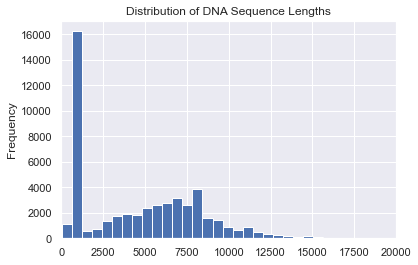

In [ ]:
sequence_lengths.plot(
    kind='hist', 
    title='Distribution of DNA Sequence Lengths', 
    bins=100,
    xlim=(0, 20000))

## binary features

In [ ]:
train_values.iloc[:, 1:].apply(pd.value_counts)

,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,growth_strain_dh5alpha,growth_strain_neb_stable,growth_strain_other,growth_strain_stbl3,growth_strain_top10,growth_strain_xl1_blue,growth_temp_30,growth_temp_37,growth_temp_other,selectable_markers_blasticidin,selectable_markers_his3,selectable_markers_hygromycin,selectable_markers_leu2,selectable_markers_neomycin,selectable_markers_other,selectable_markers_puromycin,selectable_markers_trp1,selectable_markers_ura3,selectable_markers_zeocin,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0.0,15667,48418,38972,49666,46850,15028,45861,40007,49450,49023,13927,46417,48354,48538,48275,48970,48922,1585,50389,49915,50140,48977,50056,43331,48681,45329,50064,49728,49975,49109,49182,29485,46192,49594,49850,45122,49547,44106,49390
1.0,34746,1995,11441,747,3563,35385,4552,10406,963,1390,36486,3996,2059,1875,2138,1443,1491,48828,24,498,273,1436,357,7082,1732,5084,349,685,438,1304,1231,20928,4221,819,563,5291,866,6307,1023


Text(0.5, 0, 'Proportion of sequences')

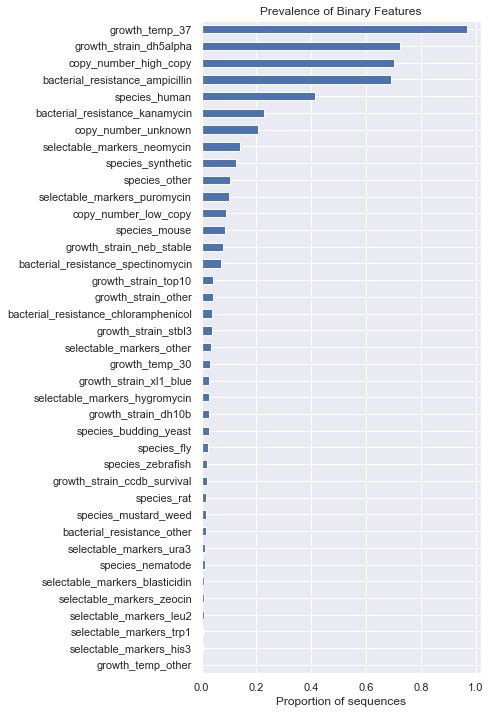

In [ ]:
sorted_binary_features = train_values.iloc[:, 1:].mean().sort_values()

ax = sorted_binary_features.plot(kind='barh',
                                 stacked=True,
                                 figsize=(5, 12),
                                 title='Prevalence of Binary Features')
ax.set_xlabel('Proportion of sequences')

## train and val labels

In [ ]:
# get the column with the max value in each row
lab_ids = pd.DataFrame(train_labels.idxmax(axis=1), columns=['lab_id'])
lab_ids.head()

,lab_id
sequence_id,
R4235,FRX9XJYW
SRXXY,Q2K8NHZY
X5FT4,Q35PXLRT
S7J6L,RKJHZGDQ
LU380,RKJHZGDQ


In [ ]:
# get the distrubtion of lab prevalence in the training set
lab_ids['lab_id'].value_counts().describe()

count    1314.000000
mean       38.366058
std       210.258552
min         1.000000
25%         7.000000
50%        12.000000
75%        27.000000
max      6654.000000
Name: lab_id, dtype: float64

In [ ]:
# Sort lab ids by prevalence
train_label_freqs = lab_ids['lab_id'].value_counts(normalize=True).sort_values(ascending=False)
print(train_label_freqs.to_string())

I7FXTVDP    0.131990
RKJHZGDQ    0.042707
GTVTUGVY    0.041815
A18S09P2    0.016940
Q2K8NHZY    0.015611
131RRHBV    0.011545
0FFBBVE1    0.010692
AMV4U0A0    0.010513
THD393NW    0.010057
G8QWQL1C    0.009125
0B9GCUVV    0.008926
ULOHU3PC    0.008768
NT9Y0D19    0.008708
3TXFYNKG    0.008014
1S515B69    0.007855
TNR495LD    0.007419
W1STLS0T    0.007320
YMHGXK99    0.006962
T9LSOTV6    0.006149
KDZ388UF    0.005911
3C2VZQ2R    0.005852
03Y3W51H    0.005713
QZ8BT14M    0.005574
7GWW4637    0.005534
KSFFKSV7    0.005475
QVAZPYQ8    0.005435
A0ADXLZU    0.005316
FHZYKEUV    0.004999
IO2FYB6G    0.004840
738FBTIL    0.004542
FRX9XJYW    0.004146
LPQY1SEL    0.004066
SSVDNEY9    0.003908
OL59ZZX5    0.003729
MQKR83SM    0.003690
37VO60SB    0.003610
JICWX3AS    0.003610
VGWO9SBA    0.003491
8T12OXHS    0.003293
JQ4YBT3Z    0.003273
XY9JOM6L    0.003253
55HTZ7T0    0.003253
ID37U3DA    0.002975
ZZJVE4HO    0.002936
9Y5EWA8O    0.002916
35MKXPL0    0.002797
VOT8OKU2    0.002757
GJKR73YA    0

In [ ]:
val_lab_ids = pd.DataFrame(val_labels.idxmax(axis=1), columns=['lab_id'])

# feature engineering

## sequence lengths

In [15]:
def get_sequence_lengths(df):

    sequence_lengths = df.sequence.apply(len)
    df['sequence_lengths'] = sequence_lengths

    return df

In [16]:
train_values = get_sequence_lengths(train_values)

## ngrams

In [17]:
def tokenize(sequence):
    #overlapping kmers
    tokens = list(sequence)
    tokens = ' '.join(tokens)
    return tokens

In [18]:
def get_ngram_features(df, train=False, ngram_range_list=[(1,5),(7,7)], write=False):

    tokens = df['sequence'].apply(tokenize)

    cv_list = []
    if train:

        for ngram_range in ngram_range_list:
            cv = CountVectorizer(token_pattern = r"(?u)\b\w+\b", ngram_range=ngram_range)
            print('fitting {}'.format(ngram_range))
            cv = cv.fit(tokens)
            dump(cv, DATA_DIR / 'count_vectorizers/count_vectorizer_{}-{}.pkl'.\
                 format(ngram_range[0],ngram_range[1]))
            cv_list.append(cv)
    else:

        for ngram_range in ngram_range_list:
            cv = load(DATA_DIR / 'count_vectorizers/count_vectorizer_{}-{}.pkl'.\
                 format(ngram_range[0],ngram_range[1]))
            cv_list.append(cv)

    n_gram_df_list = []
    for cv in cv_list:
        print('transforming')
        n_grams = cv.transform(tokens).toarray()

        n_gram_names = [x.replace(' ', '') for x in cv.get_feature_names()]
        n_gram_df = pd.DataFrame(n_grams, columns=n_gram_names, index=df.index)
        n_gram_df_list.append(n_gram_df)

    n_gram_df = pd.concat(n_gram_df_list, axis=1)
    features_df = pd.concat([df.drop('sequence', axis=1), n_gram_df], axis=1)
    
    if train or write:
        print('writing')
        features_df.to_csv(DATA_DIR / 'features_df.csv')
        
    return features_df

In [ ]:
ngram_range_list = [(1,5),(7,7)]
features_df = get_ngram_features(train_values, train, ngram_range_list, False)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


transforming
transforming


In [ ]:
import datatable as dt
features_df = dt.fread(DATA_DIR / 'features_df.csv')
features_df = features_df.to_pandas()
features_df = features_df.set_index('sequence_id')
features_df.shape

(50413, 55203)

In [1]:
del train_values

NameError: ignored

## feature engineering on validation

In [ ]:
def feature_engineering(val_values):
    
    val_values = get_sequence_lengths(val_values)
    val_features_df = get_ngram_features(val_values)

    return val_features_df

In [ ]:
val_features_df = feature_engineering(val_values)
val_features_df.shape

In [ ]:
val_features_df.to_csv(DATA_DIR / 'val_features_df.csv')

In [ ]:
import datatable as dt
val_features_df = dt.fread(DATA_DIR / 'val_features_df.csv')
val_features_df = val_features_df.to_pandas()
val_features_df = val_features_df.set_index('sequence_id')
val_features_df.shape

(12604, 55203)

In [ ]:
del val_values

# feature selection

## get rid of sparse features

In [ ]:
features_sums = features_df.sum(axis=0)

In [ ]:
features_sums.describe([.02,.05,.1,.15,.2,.6,.75])

count    5.520300e+04
mean     1.843574e+04
std      7.148482e+05
min      1.000000e+00
2%       1.000000e+00
5%       1.000000e+00
10%      1.000000e+00
15%      1.000000e+00
20%      1.000000e+00
50%      3.000000e+00
60%      9.000000e+00
75%      4.063000e+03
max      1.454330e+08
dtype: float64

In [ ]:
keep_features = features_sums.index[features_sums > 10]
print(len(keep_features))

21674


In [ ]:
# features_df = features_df[keep_features]

## get rid of correlated features

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

def remove_redundant_features(features_df, train=False):
    
    if train:
        print('cosine similarity')
        cos_sim_df = cosine_similarity(features_df.transpose())
        print(cos_sim_df.shape)
        np.savetxt("{}/cos_sim_df.csv".format(DATA_DIR), cos_sim_df, delimiter=",")

        print('redundant features')
        removed = set()
        n_features = len(cos_sim_df)
        for i in range(n_features-1):
            if i % 10000 == 0:
                print(i)
            if i in removed:
                continue
            remaining = range(i+1,n_features)
            remaining = set(remaining)
            remaining = list(remaining - removed)
            to_remove = np.array(remaining)[(cos_sim_df[i,remaining] > .99)]
            to_remove = set(to_remove)
            removed.update(to_remove)
        print(len(removed))
        
        del cos_sim_df
        
        dump(removed, '{}/feature_cols_removed.pkl'.format(DATA_DIR))
    
    removed = load('{}/feature_cols_removed.pkl'.format(DATA_DIR))
    removed = list(removed)
    features_df = features_df.drop(features_df.columns[removed],axis=1)

    del removed
    
    return features_df

In [ ]:
features_df = remove_redundant_features(features_df, train)
features_df.shape

cosine similarity


In [ ]:
val_features_df = remove_redundant_features(val_features_df)

## scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
def format_for_ml(features_df, train=False):

    # Rename our feature array
    X = features_df

    if train:
        sc = StandardScaler()
        print('fitting scaler')
        sc = sc.fit(X)
        print('dumping scaler')
        dump(sc, DATA_DIR / 'standard_scaler.pkl')
    else:
        print('loading scaler')
        sc = load(DATA_DIR / 'standard_scaler.pkl')
        
    print('transforming scaler')
    X_scaled = sc.transform(X)

    return X_scaled

In [ ]:
X_scaled = format_for_ml(features_df, train)
X_scaled.shape

fitting scaler
dumping scaler
transforming scaler


(50413, 55203)

In [ ]:
del features_df

In [ ]:
X_val_scaled = format_for_ml(val_features_df)
X_val_scaled.shape

loading scaler
transforming scaler


(12604, 55203)

In [ ]:
del val_features_df

## pca

In [ ]:
from sklearn.decomposition import PCA
def run_pca(X_scaled, train=False):
    
    if train:
        from sklearn.decomposition import PCA
        pca = PCA(12000)
        print('fitting pca')
        pca = pca.fit(X_scaled)
        dump(pca, DATA_DIR / 'pca.pkl')
    else:
        pca = load(DATA_DIR / 'pca.pkl')
        
    print('transforming pca')
    X_scaled = pca.transform(X_scaled)
    
    return X_scaled


In [ ]:
X_scaled = run_pca(X_scaled, train)
X_val_scaled = run_pca(X_val_scaled)

fitting pca
transforming pca
transforming pca


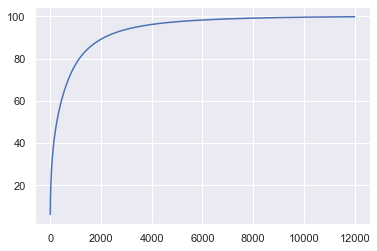

In [ ]:
pca = load(DATA_DIR / 'pca.pkl')
plt.plot(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_*100))

In [ ]:
 np.cumsum(pca.explained_variance_ratio_*100)[6000]

98.31430101618848

In [ ]:
np.savetxt("{}/X_scaled.csv".format(DATA_DIR), X_scaled, delimiter=",")
np.savetxt("{}/X_val_scaled.csv".format(DATA_DIR), X_val_scaled, delimiter=",")

In [ ]:
import datatable as dt
X_scaled = dt.fread(DATA_DIR / 'X_scaled.csv')
X_scaled = X_scaled.to_numpy()

In [ ]:
X_val_scaled = dt.fread(DATA_DIR / 'X_val_scaled.csv')
X_val_scaled = X_val_scaled.to_numpy()

In [ ]:
def keep_pca_features(df, n_keep=6000):
    
    df = df[:,:n_keep]
    
    return df

In [ ]:
X_scaled = keep_pca_features(X_scaled)
X_val_scaled = keep_pca_features(X_val_scaled)

NameError: name 'keep_pca_features' is not defined

## feature selection on validation

In [ ]:
def feature_selection(df, labels = None):
    
#     removed = load('{}/feature_cols_removed.pkl'.format(DATA_DIR))
#     removed = list(removed)
#     df = df.drop(df.columns[removed],axis=1)
    df = remove_redundant_features(df)
    
    df = format_for_ml(df)
    
    df = run_pca(df)
    
    df = keep_pca_features(df)
    
    labels = np.array(labels)
    
    return df, labels


# format y variable

In [ ]:
y = np.array(train_labels)
y_val = np.array(val_labels)

In [ ]:
np.savetxt("{}/y.csv".format(DATA_DIR), y, delimiter=",")
np.savetxt("{}/y_val.csv".format(DATA_DIR), y_val, delimiter=",")

In [ ]:
y = dt.fread(DATA_DIR / 'y.csv')
y = y.to_numpy()

In [ ]:
y_val = dt.fread(DATA_DIR / 'y_val.csv')
y_val = y_val.to_numpy()

# single model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Concatenate, Input, Layer, Softmax, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.backend import clear_session
from tensorflow.python.framework import ops
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras.activations import relu, sigmoid

Using TensorFlow backend.


## single model

In [ ]:
X_scaled.shape

(50413, 6000)

In [ ]:
y.shape

(50413, 1314)

In [ ]:
top_10_accuracy = tf.keras.metrics.TopKCategoricalAccuracy(k=10)

In [ ]:
#optimal on training data so overfit, so max
m = 1314
N = 12603
print(2*np.sqrt((m+2)*N)) # total
print(np.sqrt((m+2)*N) + 2 * np.sqrt(N / (m + 2) )) #first layer
print(m * np.sqrt(N / (m + 2) )) #second layer

8145.0716387273105
4078.725083526822
4066.3465552004886


In [ ]:
clear_session()
tf.random.set_seed(0)
model = Sequential()
hidden_layer_size = 655
reg_l =  3.249526016614285e-05
model.add(Dense(hidden_layer_size, input_shape=(X_scaled.shape[1],), activation='sigmoid',
               kernel_regularizer=regularizers.l2(reg_l),
               bias_regularizer=regularizers.l2(reg_l),
               activity_regularizer=regularizers.l2(reg_l),
               bias_initializer=initializers.GlorotUniform(seed=1),
               kernel_initializer=initializers.GlorotUniform(seed=0)))
model.add(Dropout(0.004794995243971529))
# model.add(BatchNormalization())
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', top_10_accuracy])

d=model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 454)               2724454   
_________________________________________________________________
dropout (Dropout)            (None, 454)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1314)              597870    
Total params: 3,322,324
Trainable params: 3,322,324
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = EarlyStopping(monitor='val_top_k_categorical_accuracy', patience=2)
model.fit(X_scaled, y,
          batch_size = 224,
          epochs=20, 
          verbose=1, 
          validation_data=(X_val_scaled, y_val), 
          callbacks=[callback])

Train on 50413 samples, validate on 12604 samples
Epoch 1/15
50413/50413 [==============================] - 23s 463us/sample - loss: 5.4925 - accuracy: 0.2575 - top_k_categorical_accuracy: 0.4132 - val_loss: 4.1932 - val_accuracy: 0.3968 - val_top_k_categorical_accuracy: 0.6008
Epoch 2/15
50413/50413 [==============================] - 16s 319us/sample - loss: 3.6874 - accuracy: 0.4587 - top_k_categorical_accuracy: 0.6815 - val_loss: 3.4201 - val_accuracy: 0.5092 - val_top_k_categorical_accuracy: 0.7206
Epoch 3/15
50413/50413 [==============================] - 17s 335us/sample - loss: 2.9867 - accuracy: 0.5562 - top_k_categorical_accuracy: 0.7816 - val_loss: 2.9826 - val_accuracy: 0.5693 - val_top_k_categorical_accuracy: 0.7774
Epoch 4/15
50413/50413 [==============================] - 17s 344us/sample - loss: 2.5348 - accuracy: 0.6241 - top_k_categorical_accuracy: 0.8420 - val_loss: 2.6914 - val_accuracy: 0.6100 - val_top_k_categorical_accuracy: 0.8126
Epoch 5/15
50413/50413 [==========

In [ ]:
#.9053
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

model.save('{}/models/latest_model'.format(DATA_DIR))
model.save('{}/models/{}_model'.format(DATA_DIR, timestamp))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/adamweinberger/genetic-engineering-attribution-challenge/data/models/latest_model/assets
INFO:tensorflow:Assets written to: /Users/adamweinberger/genetic-engineering-attribution-challenge/data/models/09-09-2020 21_26_16_model/assets


In [ ]:
model = tf.keras.models.load_model('{}/models/model_latest'.format(DATA_DIR),
                                               compile=True)

In [ ]:
y_probs = model.predict_proba(X_scaled)
y_val_probs = model.predict_proba(X_val_scaled)

# predict on test

## apply ML

### preprocess

In [ ]:
test_values = pd.read_csv(DATA_DIR / 'test_values.csv', index_col='sequence_id')

In [ ]:
test_features_df = feature_engineering(test_values)
X_test_scaled, _ = feature_selection(test_features_df)

transforming
transforming
loading scaler
transforming scaler
transforming pca


In [ ]:
# print(test_features_df.shape)
# removed = load('{}/feature_cols_removed.pkl'.format(DATA_DIR))
# removed = list(removed)
# test_features_df = test_features_df.drop(test_features_df.columns[removed],axis=1)
# print(test_features_df.shape)
# X_test_scaled = format_for_ml(test_features_df)
# print(X_test_scaled.shape)
# pca = load(DATA_DIR / 'pca.pkl')
# X_test_scaled = pca.transform(X_test_scaled)
# print(X_test_scaled.shape)
# X_test_scaled = X_test_scaled[:,:n_keep]
X_test_scaled.shape

In [ ]:
np.savetxt("{}/X_test_scaled.csv".format(DATA_DIR), X_test_scaled, delimiter=",")

### ensemble model

In [ ]:
model_label_0 = tf.keras.models.load_model('{}/models/model_{}'.format(DATA_DIR, model_labels[0]), 
                                               compile=True)
y_test_label_0 = model_label_0.predict(X_test_scaled)

In [ ]:
X_val_combined = np.concatenate((val_labels_probs, 
                          y_val_other_probs), axis=1)
model_combine = tf.keras.models.load_model('{}/models/model_combine.h5'.format(DATA_DIR), 
                                               compile=True)
y_test = model_combine

### single model

In [ ]:
model = tf.keras.models.load_model('{}/models/latest_model'.format(DATA_DIR),
                                               compile=True)

In [ ]:
probas = model.predict_proba(X_test_scaled)
probas

array([[2.7547703e-06, 3.7201439e-06, 1.9338497e-06, ..., 1.5036738e-06,
        4.7535009e-06, 1.3101739e-05],
       [6.2227909e-06, 1.3713850e-07, 1.0066939e-06, ..., 1.2996074e-05,
        3.4335690e-06, 1.2423910e-06],
       [8.4534266e-05, 1.9276640e-05, 3.8451497e-05, ..., 3.2259853e-05,
        6.4428823e-05, 5.3702719e-05],
       ...,
       [3.4569128e-04, 1.1728119e-04, 2.8367449e-05, ..., 7.4840093e-05,
        5.3260033e-04, 6.2709471e-04],
       [5.2390013e-05, 3.3565555e-04, 1.1974310e-04, ..., 1.4802424e-04,
        1.1051737e-03, 6.4651371e-04],
       [4.3047970e-05, 1.2215551e-05, 2.5983702e-05, ..., 2.5215162e-05,
        4.2183520e-04, 1.4497440e-02]], dtype=float32)

## submission

In [ ]:
submission_format = pd.read_csv(DATA_DIR / 'submissions/submission_format.csv', index_col='sequence_id')

In [ ]:
submission_format.shape

(18816, 1314)

In [ ]:
assert submission_format.shape == probas.shape
# assert (rf.classes_ == submission_format.columns).all()

In [ ]:
my_submission = pd.DataFrame(data=probas, 
                             columns=submission_format.columns, 
                             index=submission_format.index)
my_submission.head(25)

00Q4V31T      012VT4JK      028IO5W2      03GRNN7N  03Y3W51H  \
sequence_id                                                                     
E0VFT        2.754770e-06  3.720144e-06  1.933850e-06  5.051657e-06  0.000147   
TTRK5        6.222791e-06  1.371385e-07  1.006694e-06  2.311285e-06  0.000004   
2Z7FZ        8.453427e-05  1.927664e-05  3.845150e-05  4.518380e-05  0.000079   
VJI6E        2.250771e-05  4.042599e-06  1.691577e-05  1.090980e-04  0.000196   
721FI        6.210664e-05  4.219244e-05  7.141759e-06  1.213516e-04  0.000696   
Q9XRC        2.225986e-04  5.584777e-05  1.974960e-05  2.334448e-04  0.000226   
CUSZA        2.858694e-05  1.164516e-05  3.906843e-07  1.493401e-05  0.000270   
LPE3L        4.788698e-05  7.496382e-05  7.090146e-07  2.217198e-05  0.000050   
DLY9A        6.998196e-04  9.989333e-04  4.705191e-05  6.377155e-05  0.003062   
YMWDK        3.870509e-04  9.077494e-05  1.320797e-05  6.115994e-05  0.000071   
NBCN4        1.537152e-03  4.409851e-04  8.656594e-05  4.300524e-05  0.000116   
OZ4W0        7.358078e-04  5.758339e-05  1.891797e-05  4.033357e-05  0.000082   
MNEY0        8.014871e-05  3.872984e-05  7.325416e-06  3.485667e-05  0.000184   
KCYK3        2.390639e-07  1.416808e-07  8.001547e-07  3.782045e-07  0.000001   
X01I9        1.432894e-04  8.845492e-05  1.881404e-05  1.939204e-04  0.002460   
S050M        4.933988e-06  4.433897e-07  1.145758e-06  1.268595e-05  0.000021   
2MIDX        2.576715e-04  5.355682e-05  3.031100e-05  2.673808e-04  0.000155   
6W9QR        9.735770e-05  2.060723e-05  2.030644e-05  3.642861e-04  0.000053   
OR3VV        2.547789e-05  9.694653e-06  8.515987e-06  8.415418e-05  0.000203   
M5908        2.795196e-04  7.673362e-05  4.117240e-06  3.027811e-05  0.000075   
OPB7B        1.459016e-04  4.423773e-05  1.723193e-05  2.702409e-04  0.001766   
5EGYE        5.413155e-05  1.229251e-05  1.130567e-05  1.633275e-04  0.000244   
CFF30        1.442417e-04  1.639990e-04  4.436196e-05  4.553212e-04  0.000468   
5RT1O        8.886597e-04  3.681695e-04  1.600747e-05  6.879980e-05  0.000551   
KYDON        4.611764e-06  1.434246e-06  2.095551e-07  2.804747e-06  0.000052   

                 09MQV1TY      0A4AHRCT      0A9M05NC  0B9GCUVV      0CL7QVG8  \
sequence_id                                                                     
E0VFT        1.894981e-06  3.416385e-06  4.784341e-06  0.000027  4.263490e-06   
TTRK5        2.719386e-06  1.008711e-06  1.841871e-06  0.000006  3.416443e-06   
2Z7FZ        3.869123e-04  1.904776e-04  1.172784e-04  0.000108  3.060906e-05   
VJI6E        1.805918e-06  1.364708e-05  9.327925e-06  0.004897  9.390242e-05   
721FI        2.034149e-05  6.507715e-05  1.363752e-04  0.000226  7.929320e-05   
Q9XRC        1.630151e-05  5.952430e-05  3.763745e-05  0.032817  4.722933e-04   
CUSZA        2.265155e-06  3.033627e-06  1.608375e-05  0.000110  6.887497e-06   
LPE3L        1.492553e-06  5.926536e-06  2.014142e-06  0.000217  8.296810e-05   
DLY9A        6.391927e-05  1.575618e-04  2.018153e-04  0.000220  5.171644e-05   
YMWDK        7.810377e-06  1.218284e-05  5.384965e-05  0.010175  5.086693e-05   
NBCN4        9.789394e-05  1.079989e-04  9.868732e-05  0.003392  4.778845e-05   
OZ4W0        6.471991e-05  4.753394e-05  1.625620e-05  0.000040  4.039936e-05   
MNEY0        8.813146e-05  5.540134e-03  5.293730e-06  0.000128  3.296797e-05   
KCYK3        1.588219e-07  5.939407e-07  1.881892e-07  0.000014  9.854094e-07   
X01I9        6.798335e-06  4.500894e-05  2.934496e-05  0.000609  2.537501e-04   
S050M        1.444136e-06  1.869760e-06  7.376211e-07  0.000196  1.689689e-05   
2MIDX        3.355940e-05  3.653552e-05  3.630593e-05  0.002125  5.820401e-04   
6W9QR        3.692990e-05  5.748807e-05  3.611721e-05  0.001292  1.387409e-03   
OR3VV        2.338973e-05  4.684187e-05  1.262999e-05  0.000178  2.438362e-05   
M5908        4.244708e-06  1.995291e-05  8.452272e-06  0.167384  1.811081e-04   
OPB7B        3.014054e-05  5.294114e-05  2.0685

In [ ]:
my_submission.shape

(18816, 1314)

In [ ]:
my_submission.sum(axis=1)

sequence_id
E0VFT    1.000001
TTRK5    1.000000
2Z7FZ    1.000000
VJI6E    1.000000
721FI    1.000000
Q9XRC    1.000000
CUSZA    1.000000
LPE3L    1.000000
DLY9A    1.000000
YMWDK    1.000000
NBCN4    1.000000
OZ4W0    1.000000
MNEY0    0.999999
KCYK3    1.000000
X01I9    1.000000
S050M    1.000000
2MIDX    1.000000
6W9QR    1.000000
OR3VV    1.000000
M5908    0.999999
OPB7B    1.000000
5EGYE    1.000000
CFF30    1.000000
5RT1O    1.000000
KYDON    1.000000
A1DCI    1.000000
NWACS    1.000000
WB5P6    1.000000
MNV3P    1.000000
VZ2XK    1.000000
AMKWD    1.000000
FV42S    1.000000
RGBEN    1.000000
L89TG    1.000000
U97TP    1.000000
E0YW3    1.000000
UY16O    1.000000
FCNLC    1.000001
4IXVO    1.000000
2XSLO    1.000000
QLHWB    1.000000
U7VV7    1.000000
VIAZC    1.000000
CYRPD    1.000000
R3GQN    0.999999
883VN    1.000000
P89S7    1.000000
ZM1IM    1.000000
AF4FE    0.999999
LUU9B    0.999999
MMDDU    1.000000
733VV    1.000000
7ZF03    1.000000
OXSA7    1.000000
JYZZB    1.00000

In [ ]:
from datetime import datetime
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")

In [ ]:
my_submission.to_csv(DATA_DIR / 'submissions/{}_submission.csv'.format(timestamp))
my_submission.to_csv(DATA_DIR / 'submissions/latest_submission.csv')